## Домашнее здание №3 / New Product Forecasting

### Саутин Андрей / 396

----
План выполнения домашнего задания:

1. Подготовка данных
2. Предсказание без категориальных признаков
3. Предсказание с категориальными признаками
4.  Другие модели и генерация дополнительных признаков
5. Отправка результатов в контест на Kaggle

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from sklearn import tree
from copy import deepcopy
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.dummy import DummyRegressor
from scipy.optimize import minimize_scalar
%matplotlib inline

/home/sautin1/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Подготовка данных (1 балл)
 * Изучить признаки
 * Выделить категориальные признаки, которые можно использовать для обучения
 * Выделить датасет только с числовыми признаками
 * Выделить полезные числовые признаки

In [2]:
# data = pd.read_csv('blogData_train.csv', header=None)
data = pd.read_csv('./data/train.csv', sep=';', index_col='ID')
data.shape

(40000, 33)

In [3]:
# Посмотрим на данные
data.head()

,DEMAND,LOCATION_ID,MODEL_BRAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_DIAG_TYPE,MODEL_HEIGHT,MODEL_ID,MODEL_MEAN_SALES,...,STORE_FORMAT,STORE_OPEN_DTTM,STORE_PRICE_TYPE,STORE_REGION,STORE_RES_ABC,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR
ID,,,,,,,,,,,,,,,,,,,,,
0,0.10536,1835543262,ark,5179.7500,NaN,5.5,big,720.0,1682,NaN,...,новый формат,19MAY15:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,B,0.67,0.75,0.25,0.0,3.06
1,0.00010,1972241965,samsung,22015.3300,NaN,5.2,big,1920.0,34706,NaN,...,новый формат,20JAN16:00:00:00,розничная цена (северо-запад-днс1),северо-запад,C,0.48,0.00,1.00,0.0,2.51
2,0.00010,2027986985,samsung,15592.5900,NaN,5.0,big,1280.0,2753,NaN,...,новый формат,27APR16:00:00:00,розничная цена (дальний восток-якутск),дальний восток,A,0.64,1.00,0.00,0.0,2.72
3,0.00010,28432,alcatel,540.9533,29.0,1.8,small,128.0,1593,7.533,...,стандарт,21OCT09:00:00:00,розничная цена (северо-запад-боровичи),северо-запад,B,0.65,0.50,0.25,0.0,2.04
4,0.00010,28547,мтс,444.7300,30.0,4.0,medium,480.0,80644,16.830,...,стандарт,20MAY09:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.83,0.75,0.25,0.0,2.37


### Категориальные признаки
 * Какие категориальные признаки следует использовать в первую очередь? 
 * Есть ли категориальные признаки, которые в принципе не понятно, как использовать?

In [4]:
# Определяем категориальные признаки
# По понятным причинам 'LOCATION_ID', 'MODEL_ID' считаются числовыми признаками - их добавляем руками отдельно
Cathegorical_columns = data.columns[([isinstance(z, str) for z in data.ix[0]])]
# Cathegorical_columns = Categorical_columns.append(pd.Index(['LOCATION_ID', 'MODEL_ID']))

# а зачем было здесь писать про "добавление признаков руками", если дальше из-за этого нельзя выделить числовой датасет?
# наверное стоило использовать слова "Добавим позже"
Cathegorical_columns

Index([u'MODEL_BRAND', u'MODEL_DIAG_TYPE', u'MODEL_NAME', u'MODEL_OS',
       u'MODEL_RES_TYPE', u'MODEL_TYPE', u'STORE_BRAND_ABC',
       u'STORE_BUILDING_TYPE', u'STORE_CITY', u'STORE_CLUSTER',
       u'STORE_DIAG_ABC', u'STORE_FORMAT', u'STORE_OPEN_DTTM',
       u'STORE_PRICE_TYPE', u'STORE_REGION', u'STORE_RES_ABC'],
      dtype='object')

In [5]:
# Количество уникальных значений в категориальных признаках
dist_val = pd.DataFrame({'NoUniqueValues': [data[z].nunique() for z in Cathegorical_columns]}, 
                        index = Cathegorical_columns)

print('Количество уникальных категориальных значений: '+ str(dist_val.sum().values))
nunique_threshold = 50
print('Удаляем признаки с номерами: \n'+ str(dist_val.ix[dist_val['NoUniqueValues']>nunique_threshold].sort_values(by='NoUniqueValues', ascending=False)))

Количество уникальных категориальных значений: [845]
Удаляем признаки с номерами: 
                 NoUniqueValues
MODEL_NAME                  447
STORE_OPEN_DTTM             246


In [6]:
# Запоминаем те категориальные признаки, с которыми будем далее работать (используется далее)
Cathegorical_columns_use = dist_val.ix[dist_val['NoUniqueValues']<=nunique_threshold].axes[0]
print Cathegorical_columns_use

Index([u'MODEL_BRAND', u'MODEL_DIAG_TYPE', u'MODEL_OS', u'MODEL_RES_TYPE',
       u'MODEL_TYPE', u'STORE_BRAND_ABC', u'STORE_BUILDING_TYPE',
       u'STORE_CITY', u'STORE_CLUSTER', u'STORE_DIAG_ABC', u'STORE_FORMAT',
       u'STORE_PRICE_TYPE', u'STORE_REGION', u'STORE_RES_ABC'],
      dtype='object')


### Числовые признаки
* Какие числовые признаки следует использовать в первую очередь? 
* Есть ли числовые признаки, которые в принципе не понятно, как использовать?
* Как заполнять NaN?

In [7]:
# Выделяем числовой датасет: В данном случае удаляем все + MODEL_ID и LOCATION_ID
num_data = data.drop(Cathegorical_columns | data.columns[[1,8]], axis = 1)
num_data.columns

Index([u'DEMAND', u'MODEL_COST_AVG', u'MODEL_COUNT_SALES_DAYS', u'MODEL_DIAG',
       u'MODEL_HEIGHT', u'MODEL_MEAN_SALES', u'MODEL_WIDTH',
       u'STORE_ASSORTMENT', u'STORE_BRAND_SPECTR', u'STORE_DIAG_SPECTR',
       u'STORE_RES_SPECTR', u'STORE_TYPE_A', u'STORE_TYPE_B', u'STORE_TYPE_C',
       u'STORE_TYPE_SPECTR'],
      dtype='object')

In [8]:
# Количество NaN в числовых признаках
print('Количество NaN:')
nan_val = num_data.isnull().sum().T
nan_val
# print('Удаляем признаки с номерами: \n'+ str(nan_val.sort_values(by='NoUniqueValues', ascending=False)))

Количество NaN:


DEMAND                        0
MODEL_COST_AVG                0
MODEL_COUNT_SALES_DAYS    18917
MODEL_DIAG                  212
MODEL_HEIGHT                212
MODEL_MEAN_SALES          18917
MODEL_WIDTH                 212
STORE_ASSORTMENT            235
STORE_BRAND_SPECTR          235
STORE_DIAG_SPECTR           442
STORE_RES_SPECTR            446
STORE_TYPE_A                  0
STORE_TYPE_B                  0
STORE_TYPE_C                  0
STORE_TYPE_SPECTR             0
dtype: int64

##### Преобразовываем числовые признаки (удаляем/добавляем/заменяем nan)

In [9]:
# Здесь добавьте код по преобразованию числовых признаков
# пример
# num_data[???][num_data[???]<числовой порог]=значение

In [10]:
# Здесь добавьте код по заполнению NaN
num_data[['MODEL_MEAN_SALES']] = num_data[['MODEL_MEAN_SALES']].fillna(0)
print num_data.columns

Index([u'DEMAND', u'MODEL_COST_AVG', u'MODEL_COUNT_SALES_DAYS', u'MODEL_DIAG',
       u'MODEL_HEIGHT', u'MODEL_MEAN_SALES', u'MODEL_WIDTH',
       u'STORE_ASSORTMENT', u'STORE_BRAND_SPECTR', u'STORE_DIAG_SPECTR',
       u'STORE_RES_SPECTR', u'STORE_TYPE_A', u'STORE_TYPE_B', u'STORE_TYPE_C',
       u'STORE_TYPE_SPECTR'],
      dtype='object')


In [11]:
# Здесь добавьте код по удалению числовых признаков
num_data.drop(['MODEL_COUNT_SALES_DAYS', 'MODEL_HEIGHT', 'MODEL_WIDTH', 'STORE_ASSORTMENT'], axis = 1, inplace=True)
num_data = num_data.dropna(axis=0, how='any')
print num_data.columns
print num_data.shape

Index([u'DEMAND', u'MODEL_COST_AVG', u'MODEL_DIAG', u'MODEL_MEAN_SALES',
       u'STORE_BRAND_SPECTR', u'STORE_DIAG_SPECTR', u'STORE_RES_SPECTR',
       u'STORE_TYPE_A', u'STORE_TYPE_B', u'STORE_TYPE_C',
       u'STORE_TYPE_SPECTR'],
      dtype='object')
(39554, 11)


## Предсказание без категориальных признаков (1 балл)
### Вспомогательные функции

In [12]:
def smape_loss_func(x, y):
    SymAPE = [ 2*np.abs(x-y)/(np.abs(x)+np.abs(y))] 
    return np.mean(SymAPE)

def get_numerated_data(df, categorical_columns):
    simple_df = deepcopy(df)
    for column in categorical_columns:
        simple_df[column] = pd.Categorical.from_array(simple_df[column]).labels
    
    return simple_df

def get_binarized_data(df, categorical_columns):
    binary_df = deepcopy(df)
    for column in categorical_columns:
        binary_df = pd.concat([binary_df, pd.get_dummies(binary_df[column], prefix=column, prefix_sep=': ')], axis=1)
        del binary_df[column]
    
    return binary_df

def split_to_numpy(df, y_column_name):
    #print df
    #print y_column_name
    data_x = df.drop(y_column_name, axis=1).values.astype(np.float32)
    data_y = df[y_column_name].values.astype(np.float32)
    column_names = df.drop(y_column_name, axis=1).columns
    
    return data_x, data_y, column_names

def split_train_test(df, test_size=0.5, random_state=42, y_column_name='y'):
    X = np.asarray(df.drop(y_column_name, axis=1))
    y = np.asarray(df[y_column_name]).ravel()
    trainX, testX, trainY, testY = cross_validation.train_test_split(X, y, test_size=test_size, random_state=42)
    return trainX, testX, trainY, testY

### Необходимые функции

In [13]:
def show_plot(n_est, res, title="", ylabel="acc"):
    fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][1] for x in n_est], 'ro')
#     ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
#     plt.xlabel("n_estimators")
#     plt.ylabel(ylabel)
#     plt.title("Test result")
#     plt.show()
    
#     fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][0] for x in n_est], 'bo')
    ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
    plt.xlabel("n_estimators")
    plt.ylabel("acc")
    plt.title(title)
    plt.show()

def get_results_dummy_reg(acc=smape_loss_func, verbose=True, strg ='mean', const=None):
    results = dict()
    reg = DummyRegressor(strategy=strg, constant=const)
    reg.fit(trainX, trainY)
    predict = reg.predict(testX)
    results[1] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
    if verbose:
        print("Accuracy: " + str(results[1][1]))
    return results

def get_results_baggind_rsm(n_est, max_samples, max_features, acc=smape_loss_func, verbose=True):
    results = dict()
    for i in n_est:
        reg = BaggingRegressor(n_estimators=i,
                          max_samples=max_samples, max_features=max_features, random_state=42, n_jobs=-1, verbose=0)
        reg.fit(trainX, trainY)
#         results[i] = (mse(reg.predict(trainX), trainY), mse(reg.predict(testX), testY))
        predict = reg.predict(testX)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_rf(n_est, oob=False, verbose=True, acc=smape_loss_func, max_features='sqrt'):
    results = dict()
    for i in n_est:
        reg = RandomForestRegressor(n_estimators=i, n_jobs=-1, random_state=42, verbose=0,
                                    oob_score=oob, max_features=max_features)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if oob:
            results[i] = (reg.oob_score_, acc(predict, testY))
        else:
            results[i] = (acc(trainY, reg.predict(trainX)), acc(testY,predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_erte(n_est, verbose=True,acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = ExtraTreesRegressor(n_estimators=i, n_jobs=-1, random_state=42, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        results[i] = (acc(trainY,reg.predict(trainX)), acc(predict, testY))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_gbdt(n_est, verbose=True, init=None, acc=smape_loss_func, min_max_filter=True, max_val=1, min_val=0.001, max_depth=3):
    results = dict()
    for i in n_est:
        if init is not None:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=42, max_depth=max_depth, verbose=0, init=init)
        else:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=42, max_depth=max_depth, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if min_max_filter:
            predict = np.minimum(np.maximum(predict, min_val),max_val)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))    
    return results

def get_optimal(results):
    results = sorted(results, key=lambda x: x[1])

### Делим выборку на обучение и контроль

In [113]:
trainX, testX, trainY, testY = split_train_test(df = num_data, test_size=0.3,  y_column_name='DEMAND')

### DummyRegressor
* Самый простой классификатор на числовых признаках используется как база для сравнения

In [131]:
%time results = get_results_dummy_reg()
%time results = get_results_dummy_reg(strg='constant', const=0.0001)

Accuracy: 1.26016395526
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 3.27 ms
Accuracy: 1.13137239143
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.56 ms


### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

** Каким стоит брать размер bootstrap выборки и RSM выборки ** 
Например: 
**Bagging:** 0.5 от размера тестовой выборки.

**RSM:** 0.5 от размера тестовой выборки.

Count of estimators: 5, accuracy: 1.23023847433
Count of estimators: 9, accuracy: 1.2207910569
Count of estimators: 13, accuracy: 1.21654261424
Count of estimators: 17, accuracy: 1.2213740033
Count of estimators: 21, accuracy: 1.22245114468
Count of estimators: 25, accuracy: 1.22133931032
Count of estimators: 29, accuracy: 1.21908583305
Count of estimators: 33, accuracy: 1.22165363087
Count of estimators: 37, accuracy: 1.22508999724
Count of estimators: 41, accuracy: 1.22819780618
Count of estimators: 45, accuracy: 1.22703992559
Count of estimators: 49, accuracy: 1.22745975017
Count of estimators: 53, accuracy: 1.22791937274
Count of estimators: 57, accuracy: 1.22732358252
Count of estimators: 61, accuracy: 1.22779537954
Count of estimators: 65, accuracy: 1.22899921012
Count of estimators: 69, accuracy: 1.22653581671
Count of estimators: 73, accuracy: 1.22485772616
Count of estimators: 77, accuracy: 1.224947711
CPU times: user 13.5 s, sys: 7.63 s, total: 21.1 s
Wall time: 44 s


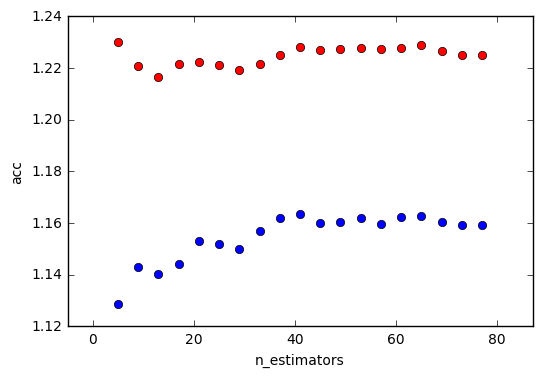

In [137]:
n_est = range(1, 30, 2)
%time results = get_results_baggind_rsm(n_est, 0.5, 0.33, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 5, accuracy: 1.1925190042
Count of estimators: 9, accuracy: 1.23377637017
Count of estimators: 13, accuracy: 1.24333962031
Count of estimators: 17, accuracy: 1.24459059112
Count of estimators: 21, accuracy: 1.24559211629
Count of estimators: 25, accuracy: 1.24483271065
Count of estimators: 29, accuracy: 1.24429055033
Count of estimators: 33, accuracy: 1.24378197193
Count of estimators: 37, accuracy: 1.24245502383
Count of estimators: 41, accuracy: 1.24318946143
Count of estimators: 45, accuracy: 1.24334566592
Count of estimators: 49, accuracy: 1.2433957586
Count of estimators: 53, accuracy: 1.24348874198
Count of estimators: 57, accuracy: 1.24321729444
Count of estimators: 61, accuracy: 1.24306273798
Count of estimators: 65, accuracy: 1.24266443691
Count of estimators: 69, accuracy: 1.2426909459
Count of estimators: 73, accuracy: 1.24315689961
Count of estimators: 77, accuracy: 1.24258154553
CPU times: user 1min 53s, sys: 744 ms, total: 1min 54s
Wall time: 38.5 s


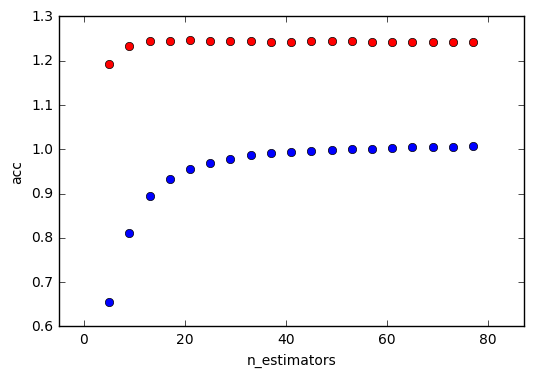

In [138]:
n_est = range(1, 20, 2)
%time results = get_results_rf(n_est, max_features=trainX.shape[1] / 3)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 5, accuracy: 1.17465772179
Count of estimators: 9, accuracy: 1.21682297641
Count of estimators: 13, accuracy: 1.23035026341
Count of estimators: 17, accuracy: 1.23699672053
Count of estimators: 21, accuracy: 1.23934856506
Count of estimators: 25, accuracy: 1.24076164906
Count of estimators: 29, accuracy: 1.24285100815
Count of estimators: 33, accuracy: 1.24361526028
Count of estimators: 37, accuracy: 1.2428514858
Count of estimators: 41, accuracy: 1.24319559807
Count of estimators: 45, accuracy: 1.24322810395
Count of estimators: 49, accuracy: 1.24313452045
Count of estimators: 53, accuracy: 1.24293486027
Count of estimators: 57, accuracy: 1.242786716
Count of estimators: 61, accuracy: 1.24347449435
Count of estimators: 65, accuracy: 1.24414792174
Count of estimators: 69, accuracy: 1.24459850662
Count of estimators: 73, accuracy: 1.24420049888
Count of estimators: 77, accuracy: 1.24390796391
CPU times: user 2min 29s, sys: 684 ms, total: 2min 30s
Wall time: 53 s


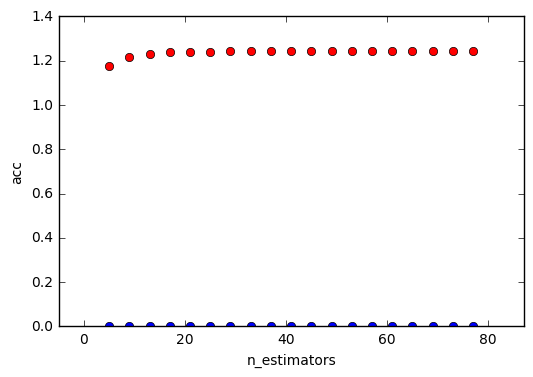

In [139]:
n_est = range(1, 20, 2)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

## Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 5, accuracy: 1.25562833669
Count of estimators: 9, accuracy: 1.255264607
Count of estimators: 13, accuracy: 1.25317955482
Count of estimators: 17, accuracy: 1.25285819807
Count of estimators: 21, accuracy: 1.25113817978
Count of estimators: 25, accuracy: 1.24956376781
Count of estimators: 29, accuracy: 1.24757136055
Count of estimators: 33, accuracy: 1.24705038405
Count of estimators: 37, accuracy: 1.24549266104
Count of estimators: 41, accuracy: 1.24512359627
Count of estimators: 45, accuracy: 1.24368335805
Count of estimators: 49, accuracy: 1.24265725299
Count of estimators: 53, accuracy: 1.24353120086
Count of estimators: 57, accuracy: 1.24421630718
Count of estimators: 61, accuracy: 1.2444696419
Count of estimators: 65, accuracy: 1.24404958162
Count of estimators: 69, accuracy: 1.24490298168
Count of estimators: 73, accuracy: 1.24404298452
Count of estimators: 77, accuracy: 1.24384331409
CPU times: user 19.4 s, sys: 40 ms, total: 19.4 s
Wall time: 19.4 s


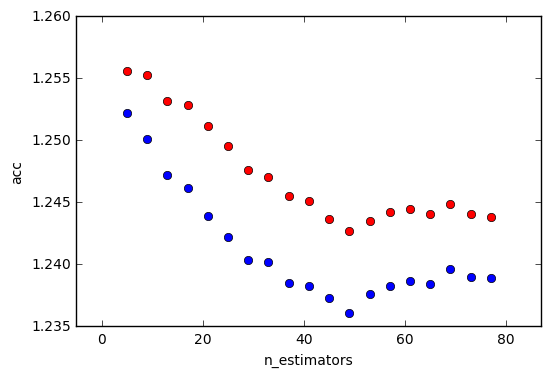

In [144]:
n_est = range(40, 60, 2)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод
Переобучаются ExtraDT, остальные методы показывают результаты на одном уровне (в пределах погрешности).

Для RF и Baggin+RSM оптимальные значения кол-ва близко к 20.

Для GBDT оптимальное количество алгоритмов находится в районе 50.

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**
ERT переобучается очень сильно, остальные модели (кроме константной) показывают довольно близкие результаты.
Из неконстантных наиболее успешно отрабатывает бэггинг на ~30 эстиматорах и случайный лес на ~5 деревьях.

## Использование категориальных признаков (1 балл)
* Проведите аналогичный экспермент при наличии категориальных признаков

### Обучение и Контроль

In [14]:
Cathegorical_columns

Index([u'MODEL_BRAND', u'MODEL_DIAG_TYPE', u'MODEL_NAME', u'MODEL_OS',
       u'MODEL_RES_TYPE', u'MODEL_TYPE', u'STORE_BRAND_ABC',
       u'STORE_BUILDING_TYPE', u'STORE_CITY', u'STORE_CLUSTER',
       u'STORE_DIAG_ABC', u'STORE_FORMAT', u'STORE_OPEN_DTTM',
       u'STORE_PRICE_TYPE', u'STORE_REGION', u'STORE_RES_ABC'],
      dtype='object')

In [15]:
# Для обучения используются полезные категориальные признаки
bin_data = get_binarized_data(data, Cathegorical_columns_use)
print(bin_data.shape)

(40000, 171)


##### Исключаем лишние произнаки, заменяем NaN

In [16]:
# Удаляем лишние категоримальные признаки
bin_data.drop(Cathegorical_columns[[2, 12]], axis = 1, inplace=True)
print bin_data.shape

(40000, 169)


In [17]:
# Удаляем лишние числвые признаки признаки
bin_data.drop(['MODEL_COUNT_SALES_DAYS', 'MODEL_HEIGHT', 'MODEL_WIDTH', 'STORE_ASSORTMENT'], axis = 1, inplace = True)
print bin_data.shape

(40000, 165)


In [18]:
# Заменяем NaN
# bin_data.fillna(значение, inplace = True)
bin_data[['MODEL_MEAN_SALES']] = bin_data[['MODEL_MEAN_SALES']].fillna(0)
bin_data = bin_data.dropna(axis=0, how='any')
print bin_data.shape

(39554, 165)


In [19]:
# Делим выборку на обучение и контроль
trainX, testX, trainY, testY = split_train_test(df = bin_data, test_size=0.3,  y_column_name='DEMAND')

### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 5, accuracy: 1.13943089976
Count of estimators: 9, accuracy: 1.18934922094
Count of estimators: 13, accuracy: 1.20219222555
Count of estimators: 17, accuracy: 1.20842287261
Count of estimators: 21, accuracy: 1.20907291327
Count of estimators: 25, accuracy: 1.20946736322
Count of estimators: 29, accuracy: 1.20995782136
Count of estimators: 33, accuracy: 1.21104392882
Count of estimators: 37, accuracy: 1.2109481965
Count of estimators: 41, accuracy: 1.21143937811
Count of estimators: 45, accuracy: 1.21080408612
Count of estimators: 49, accuracy: 1.21155534647
Count of estimators: 53, accuracy: 1.21170284961
Count of estimators: 57, accuracy: 1.2109121663
Count of estimators: 61, accuracy: 1.21078332722
Count of estimators: 65, accuracy: 1.2113067759
Count of estimators: 69, accuracy: 1.21069518102
Count of estimators: 73, accuracy: 1.21106386774
Count of estimators: 77, accuracy: 1.2105245562
CPU times: user 39.1 s, sys: 12.5 s, total: 51.6 s
Wall time: 10min 39s


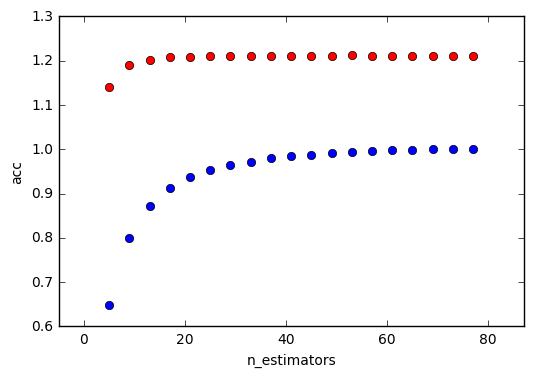

In [174]:
n_est = range(1, 20, 2)
# %time results = get_results_baggind_rsm(n_est, 0.9, 0.9, verbose=True)
# %time results = get_results_baggind_rsm(n_est, 0.8, trainX.shape[1] / 3, verbose=True)
# %time results = get_results_baggind_rsm(n_est, 0.7, trainX.shape[1] / 3, verbose=True)
# %time results = get_results_baggind_rsm(n_est, 0.5, trainX.shape[1] / 3, verbose=True)
%time results = get_results_baggind_rsm(n_est, 0.91, 0.91, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 0.986551120808
Count of estimators: 3, accuracy: 1.11697305571
Count of estimators: 5, accuracy: 1.18479547078
Count of estimators: 7, accuracy: 1.20636975276
Count of estimators: 9, accuracy: 1.21750775003
Count of estimators: 11, accuracy: 1.2191125739
Count of estimators: 13, accuracy: 1.2186945059
Count of estimators: 15, accuracy: 1.21748547847
Count of estimators: 17, accuracy: 1.21958981208
Count of estimators: 19, accuracy: 1.21864769694
CPU times: user 22.3 s, sys: 104 ms, total: 22.4 s
Wall time: 10.2 s


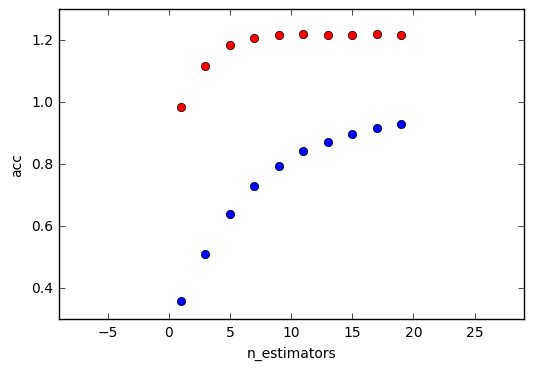

In [177]:
n_est = range(1, 20, 2)
%time results = get_results_rf(n_est, max_features=trainX.shape[1] / 3)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.98787789468
Count of estimators: 20, accuracy: 1.98365737576
Count of estimators: 30, accuracy: 1.9817152687
Count of estimators: 40, accuracy: 1.98163912705
Count of estimators: 50, accuracy: 1.98285835431
Count of estimators: 60, accuracy: 1.98346790057
Count of estimators: 70, accuracy: 1.98412016812
Count of estimators: 80, accuracy: 1.98429575357
Count of estimators: 90, accuracy: 1.9843401346
Count of estimators: 100, accuracy: 1.98458447444
Count of estimators: 110, accuracy: 1.98548507553
Count of estimators: 120, accuracy: 1.98418310327
Count of estimators: 130, accuracy: 1.98383253052
Count of estimators: 140, accuracy: 1.98409054326
Wall time: 13min 9s


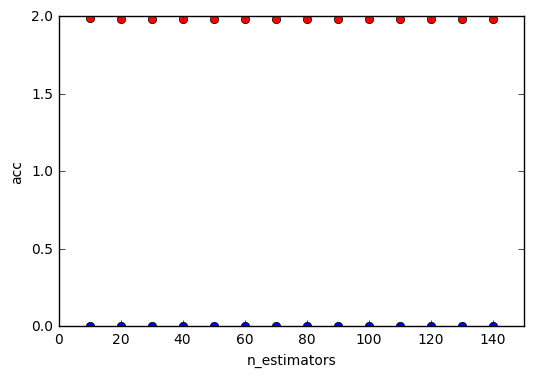

In [168]:
n_est = range(1, 20, 2)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

### Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 50, accuracy: 1.23608262048
Count of estimators: 54, accuracy: 1.23501299423
Count of estimators: 58, accuracy: 1.23508817236
Count of estimators: 62, accuracy: 1.23505040674
Count of estimators: 66, accuracy: 1.23394381272
CPU times: user 2min 3s, sys: 664 ms, total: 2min 4s
Wall time: 2min 4s


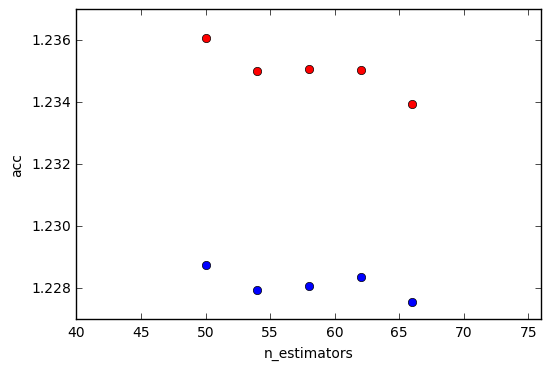

In [180]:
n_est = range(50, 75, 2)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**
Интересен тот факт, что наилучшие результаты во всех методах кроме градиентного бустинга дает малое количество (<10) базовых эстиматоров. Все так же наблюдается сильное переобучение у ERT. 

## Другие модели и генерация дополнительных признаков (2 балла)

* На основании сделанных выводов, предложите другой вариант алгоритма ML, который должен показать лучший результат
* Направляния:
    -- использовать принципиально другое семейство алгоритмов (NN, GB+kNN, LinearRegression, композиция Baggin и GBDT)
    -- исключить бесполезные фичи из обучающей выборки (полезность фич проанализировать с помощью RF);
    -- исключить фичи, в которых есть NaN; сделать восстановление NaN более интеллектуально;
    -- преобразовать катеориальные признаки так, чтобы получились числовые.

In [20]:
# избавимся от бесполезных признаков

reg = RandomForestRegressor(n_estimators=10, n_jobs=-1, verbose=0, max_features=trainX.shape[1] / 3)
reg.fit(trainX, trainY)
print reg.feature_importances_.min(), reg.feature_importances_.max()

0.0 0.0930388607071


In [21]:
print trainX.shape
importance_threshold = 5e-4
useful_features = reg.feature_importances_ > importance_threshold
trainX_use, testX_use = trainX[:,useful_features], testX[:,useful_features]
print trainX_use.shape, testX_use.shape

(27687, 164)
(27687, 107) (11867, 107)


In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [23]:
def get_results_lin_reg(acc=smape_loss_func, verbose=True):
    results = dict()
    reg = LinearRegression(n_jobs=-1)
    reg.fit(trainX, trainY)
    predict = reg.predict(testX)
    results[1] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
    if verbose:
        print("Accuracy: " + str(results[1][1]))
    return results

def get_results_knn_bag(n_est, max_samples, max_features, acc=smape_loss_func, verbose=True):
    results = dict()
    
    for i in n_est:
        reg = BaggingRegressor(base_estimator=KNeighborsRegressor(), n_estimators=i,
                               max_samples=max_samples, max_features=max_features, n_jobs=-1, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_knn(n_neighb, verbose=True, acc=smape_loss_func):
    results = dict()
    for i in n_neighb:
        reg = KNeighborsRegressor(n_neighbors=i, n_jobs=-1)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_gbdt_bag(n_est, verbose=True, init=None, acc=smape_loss_func, min_max_filter=True, 
                         max_val=1, min_val=0.001, max_depth=3, subsample=1.0, max_features=None):
    results = dict()
    for i in n_est:
        reg = GradientBoostingRegressor(n_estimators=i, random_state=42, max_depth=max_depth, 
                                        verbose=0, init=init, subsample=subsample, max_features=max_features)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if min_max_filter:
            predict = np.minimum(np.maximum(predict, min_val),max_val)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))    
    return results

In [202]:
%time results = get_results_lin_reg()

Accuracy: 1.30517636681
CPU times: user 748 ms, sys: 152 ms, total: 900 ms
Wall time: 585 ms


Count of estimators: 1, accuracy: 1.00664821213
Count of estimators: 3, accuracy: 1.14934448172
Count of estimators: 5, accuracy: 1.21552106212
Count of estimators: 7, accuracy: 1.2368960306
Count of estimators: 9, accuracy: 1.24459729946
Count of estimators: 11, accuracy: 1.25167046203
Count of estimators: 13, accuracy: 1.25430361958
Count of estimators: 15, accuracy: 1.25632604933
Count of estimators: 17, accuracy: 1.25916982028
Count of estimators: 19, accuracy: 1.25870714718
CPU times: user 2min 18s, sys: 380 ms, total: 2min 18s
Wall time: 45.5 s


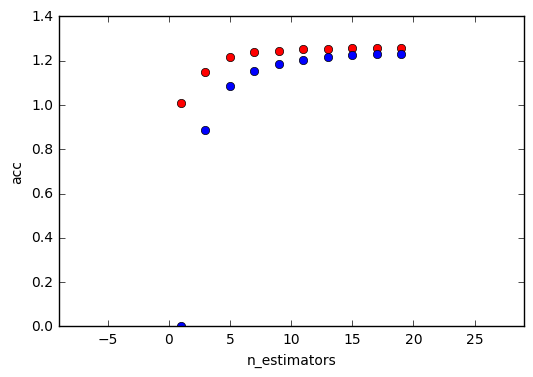

In [205]:
n_neighb = range(1, 10, 2)
%time results = get_results_knn(n_neighb)
show_plot(n_est, results)

In [ ]:
n_est = range(1, 2, 2)
%time results = get_results_knn_bag(n_est, max_samples=0.8, max_features=trainX.shape[1] / 3)
show_plot(n_est, results)

Count of estimators: 1, accuracy: 1.23627680099
Count of estimators: 3, accuracy: 1.22494814465


Process PoolWorker-1304:
Process PoolWorker-1306:
Process PoolWorker-1305:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-1303:
Traceback (most recent call last):
  File "/home/sautin1/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sautin1/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/sautin1/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
    self._target(*self._args, **self._kwargs)
  File "/home/sautin1/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sautin1/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/sautin1/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/sautin1/anaconda2/lib/python2.7/multiprocessing/pool.py", line 117, in worker
    self._ta

Count of estimators: 40, accuracy: 1.23726138281
Count of estimators: 50, accuracy: 1.23477830203
Count of estimators: 60, accuracy: 1.23231619786
Count of estimators: 70, accuracy: 1.23381562161
Count of estimators: 80, accuracy: 1.23447475743
Count of estimators: 90, accuracy: 1.23696119751
CPU times: user 1min 14s, sys: 452 ms, total: 1min 14s
Wall time: 1min 21s


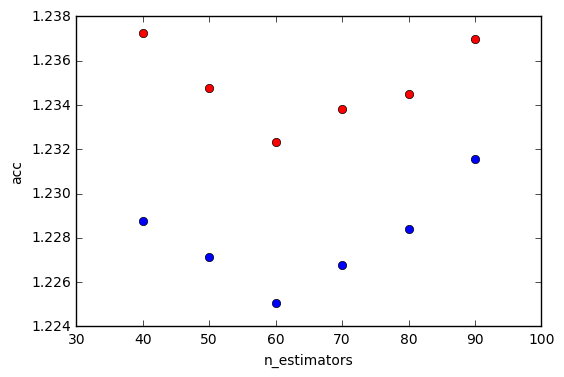

In [212]:
n_est = range(40, 100, 10)
%time results = get_results_gbdt_bag(n_est, subsample=0.8, max_features=trainX.shape[1] / 3)
show_plot(n_est, results)

Count of estimators: 1, accuracy: 0.925586607174
Count of estimators: 3, accuracy: 1.06559032338
Count of estimators: 5, accuracy: 1.13325309358
Count of estimators: 7, accuracy: 1.17004662507
Count of estimators: 9, accuracy: 1.18741142771
Count of estimators: 11, accuracy: 1.19701997597
Count of estimators: 13, accuracy: 1.20074705696
Count of estimators: 15, accuracy: 1.2032284316
Count of estimators: 17, accuracy: 1.20500092401
Count of estimators: 19, accuracy: 1.20468676986
CPU times: user 1min 10s, sys: 368 ms, total: 1min 10s
Wall time: 26.9 s


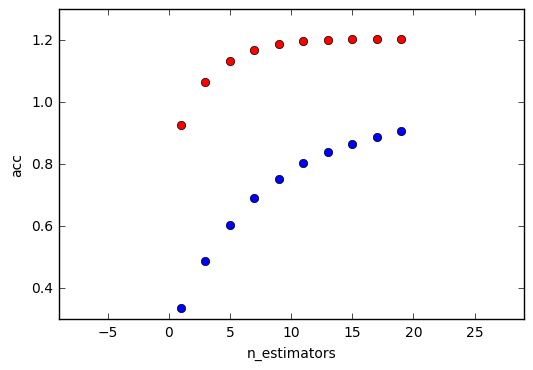

In [24]:
n_est = range(1, 20, 2)
%time results = get_results_rf(n_est, max_features=trainX.shape[1] / 3)
show_plot(n_est, results)

Count of estimators: 1, accuracy: 0.901128391417
Count of estimators: 3, accuracy: 1.04452151535
CPU times: user 9.92 s, sys: 52 ms, total: 9.97 s
Wall time: 6.1 s


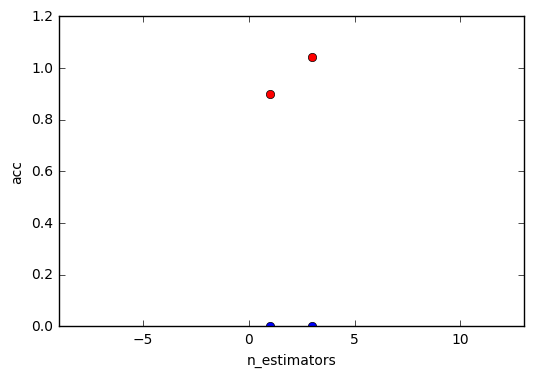

In [26]:
n_est = range(1, 5, 2)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

### Вывод

ERT с одним эстиматором дает наилучший результат.
Фильтрация признаков позволила немного улучшить результаты.

## Отправка результатов в контест на Kaggle (оценивается по результатам в Leaderboard)

In [62]:
test = pd.read_csv('./data/test.csv', sep=';',decimal= '.', index_col='ID')

In [63]:
# Предобработка тестовой выборки (добавляем\удаляем признаки, предобработка NaN и пр.)
test_data = get_binarized_data(test, Cathegorical_columns_use)

In [64]:
# test_data = test_data[test_data.columns[useful_features]]
# test_data.fillna(0, inplace=True)
print test_data.shape

(11296, 777)


In [65]:
# Все отсутствующие в тестовой выборке столбцы полагаем 0
add_columns = bin_data.columns[1:].difference(test_data.columns)
test_data = pd.merge(test_data, bin_data.ix[test_data.index][add_columns], how='inner', left_index=True, right_index=True)
test_data[add_columns]=0

# Оставляем только столбцы обучающей выборки (целевая переменная в обучающей выборке отсутствует)
test_data = test_data[bin_data.columns[1:]]

test_data.fillna(-10, inplace=True)
print test_data.shape

(11296, 164)


In [66]:
# Обучающая выборка
trainX, _, trainY, _ = split_train_test(df = bin_data, test_size=0,  y_column_name='DEMAND')

In [67]:
# Обучаем финальный алгоритм
final_regressor = ExtraTreesRegressor(n_estimators=1, n_jobs=-1, random_state=1234, verbose=0)
final_regressor.fit(trainX, trainY)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1, n_jobs=-1, oob_score=False, random_state=1234,
          verbose=0, warm_start=False)

In [68]:
# Предсказание интенсивности
test_predict = final_regressor.predict(np.asarray(test_data))

In [69]:
# Сохраняем в csv-файл
test['DEMAND'] = test_predict
test[['DEMAND']].to_csv('./data/submission_gbdt2.csv', sep = ',', index = True)